# Amazon Reviews - Sentiment Model Experimentation

### Imports

In [ ]:
!conda install -y -c conda-forge fastparquet scikit-learn arrow-cpp parquet-cpp pyarrow numpy

In [3]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import pandas as pd
import subprocess
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import gzip
from io import BytesIO
import zipfile
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
import nltk
from fastparquet import write
from fastparquet import ParquetFile
import s3fs
import pyarrow.parquet as pq
import pickle
import glob
import ast 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics


### Configs and Global Vars

In [4]:
configs = {
    'aws_region' :  'us-east-1',
    'bucket_name': 'demos-amazon-reviews',
    'prefix' : 'preprocessed_reviews_csvs', #only use this if you want to have your files in a folder 
    'index_key' : 'review_date_str',
    'file_extension' :'.csv'
   
}

global_vars = {}

### Environment Setup

Setting up the environment involves ensuring all the corret session and IAM roles are configured. We also need to ensure the correct region and bucket is made available.

In [6]:
def setup_env(configs, global_vars):
    
    sess = sagemaker.Session()
    
    role = get_execution_role()

    AWS_REGION = configs['aws_region']
    s3 = boto3.resource('s3')

    s3_bucket = s3.Bucket(configs['bucket_name'])

    if s3_bucket.creation_date == None:
    # create S3 bucket because it does not exist yet
        print('Creating S3 bucket {}.'.format(bucket))
        resp = s3.create_bucket(
            ACL='private',
            Bucket=bucket
        )
    else:
        print('Bucket already exists')
        
    global_vars['role'] = role
    global_vars['sess'] = sess
    global_vars['s3'] = s3
    global_vars['s3_bucket'] = s3_bucket
    
    return global_vars

global_vars = setup_env(configs, global_vars)

NoCredentialsError: Unable to locate credentials

### Create Data Manifest

At this step, we need to create an index of all the files we're going to be using for this experiment and model building. Now, we don't want to download all of the data at once, or we're going to cause a lot of I/O activity for your Notebook Instance. 

What we're going to do is first create a path index to where the files live on S3. From there, we can do some sampling to get to see what the data looks like, do some basic sampling stats on the data, to get a better handle on how we should build a model, and then move to using all the data to build a robust model!

In [ ]:
def create_dataset_manifest(configs, global_vars):
    
    interval_printer_idx = 100
    idx = 0
    1
    conn = global_vars['s3_bucket']
    file_format = configs['file_extension']
    index_key = configs['index_key']+'='
    s3_prefix = configs['prefix']+'/'
    manifest = []    
    for file in conn.objects.filter(Prefix=s3_prefix):
        path = file.key
#         print(file)
        if (file_format in path):
#             print(path)
            relative_path = path.replace(configs['prefix'],'')
            date = relative_path.split('/')[1].replace(index_key,'')

            man = {'idx':idx, 'path':relative_path, 'path_with_prefix':path, 'date':date}
            manifest.append(man)  
            idx += 1
            if (idx % interval_printer_idx) == 0:
                print('Processed {} files'.format(idx))
    print('Training Dataset Size {}'.format(len(manifest)))
    return manifest
            
manifest = create_dataset_manifest(configs, global_vars)   
    

In [ ]:
def count_lines(configs, global_vars, entry):
        
    s3 = boto3.client('s3')

    resp = s3.select_object_content(
        Bucket=configs['bucket_name'],
        Key=entry['path_with_prefix'],
        ExpressionType='SQL',
        Expression="SELECT count(*) FROM s3object s",
        InputSerialization = {'CSV':
                              {"FileHeaderInfo": "Use", 
                               "AllowQuotedRecordDelimiter": True,
                               "QuoteEscapeCharacter":"\\",
                              }, 
                              'CompressionType': 'NONE'},
        OutputSerialization = {'CSV':{}},
    )
    
    for event in resp['Payload']:
        if 'Records' in event:
            records = event['Records']['Payload'].decode('utf-8')
#             print('Rows:',records)
            return(int(records))
    
count_lines(configs, global_vars, manifest[240])

### Explore Manifest Stats

Given that we know what the index of our manifest is partitioned by, let's do some simple stats to learn more about our manifest so we can make some informed decisions for our sampling and modelling

In [ ]:
def generate_manifest_statistics(configs, global_vars, manifest):
    
    date_cnt = {}
    stats = {}

    for entry in manifest:
        
        date = entry['date']
        cnt = count_lines(configs, global_vars, entry)
        date_cnt[date] = cnt
        print(date,cnt)

    tmp = []
    for date, cnt in date_cnt.items():
        itm = {'date':date, 'files':cnt}
        tmp.append(itm)
    df_stats = pd.DataFrame(tmp)
    df_stats.plot.bar(x='date', y='files', figsize=(40,10))  
    df_stats.plot.kde()
    print('Total folders {}'.format(df_stats.shape[0]))
    print('Total Files {}'.format(df_stats.sum()['files']))
    print('Date with most files {}. Files: {}'.format(df_stats.max()['date'], df_stats.max()['files']))
    print('Date with least files {}. Files: {}'.format(df_stats.min()['date'], df_stats.min()['files']))
    print('File Kurtosis/Skew {}/{}'.format(df_stats.kurtosis()['files'], df_stats.skew()['files']))

    notes = '''
        once we examine the distribution, we can determine how we are going to sample our manifest to get a better 
        understanding of our reviews. Remember the plot only represents the number of files in each folder. but
        there is a linear relationship between the number of files, and the number of reviews per bin'''
    
    print(notes)
    
    return df_stats
    
manifest_df_stats = generate_manifest_statistics(configs,global_vars, manifest)

### Generate Sample Manifest

Now we're going to generate a sample of our dataset to ensure that we get some views of how the data looks and feels across the years.

In [ ]:
def generate_sample_dataset(configs, manifest, manifest_df_stats, sample_size_pct = 0.01, strategy = 'binned_normal'):
    
    dfs_sampled = []
    index_key = configs['index_key']+'='

    notes = '''
        Based on the manifest inspection, we can now use a suitable sampling strategy in order to generate a smaller 
        manifest to work on locally.'''
    
    strategies = ['statified', 'random', 'clustered', 'systematic', 'binned_normal']
    if strategy in strategies:
        print('Using {} Strategy'.format(strategy))
    else:
        print('Please use one of these strategies {}'.format(strategies))
    
    if strategy is 'binned_normal':
        sample_meta = {}
        #we take a pct of each of the rows, and then use random to select within each bin
        #workout the overall pct we need to take
#         sample_pct = float(manifest_df_stats.shape[0] * sample_size)
        for idx,row in manifest_df_stats.iterrows():
            to_sample = int(row['files'] * sample_size_pct)
            if to_sample < 1:
                to_sample = 1
            date = row['date']    
            tmp = {'rows':row['files'], 'samples': to_sample, 'sampled_added':0}
            sample_meta[date] = tmp
            
#         print(sample_meta)
        #now we generate a new manifest
        
        sampled_manifest = []
        for entry in manifest:

            date = entry['path'].split('/')[1].replace(index_key,'')
            #get the meta data 
            meta = sample_meta[date]
            to_skip = meta['samples']
            if to_skip == 1:
                to_skip = 1
            full_path = 's3://'+configs['bucket_name']+'/'+entry['path_with_prefix']
            df = pd.read_csv(full_path, nrows=int(to_skip), header=0, error_bad_lines=False, escapechar="\\")
            print(date, df.shape)
            dfs_sampled.append(df)
        
    elif strategy in strategies:
        print('Other Stratigies will be supported Soon!')
    
    sampled_data = pd.concat(dfs_sampled)

    print('New Dataset Length {}'.format(sampled_data.shape[0]))
    
    return sampled_data
    
sampled_data = generate_sample_dataset(configs, manifest, manifest_df_stats)

In [4]:
def save_load_sample_df_to_file(df, path = 'data', file_name_prefix='', operation='save', chunkSize = 100000):
    
    
    loaded = []
    #first split the df as it's too big probably
    listOfDf = list()
    if operation == 'save':

        numberChunks = len(df) // chunkSize + 1
        for i in range(numberChunks):
            listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
            
        for i in range(0, len(listOfDf)):
            chunk_df = listOfDf[i]
            df_tmp_name_prefix = '{}/{}_part_{}.pkl'.format(path, file_name_prefix, str(i))
            chunk_df.to_pickle(df_tmp_name_prefix) 
                       
        return df
                       
    if operation == 'load':
        root_name = '{}/{}_*.pkl'.format(path, file_name_prefix)
        files = glob.glob(root_name)
        for fl in files:       
            print(fl)
            df = pd.read_pickle(fl)
            loaded.append(df)
                       
        return pd.concat(loaded)
    
sampled_data = save_load_sample_df_to_file(None, path='data', file_name_prefix = 'sample_df', operation='load')   

data/sample_df_part_7.pkl
data/sample_df_part_5.pkl
data/sample_df_part_14.pkl
data/sample_df_part_6.pkl
data/sample_df_part_12.pkl
data/sample_df_part_4.pkl
data/sample_df_part_8.pkl
data/sample_df_part_1.pkl
data/sample_df_part_2.pkl
data/sample_df_part_9.pkl
data/sample_df_part_0.pkl
data/sample_df_part_3.pkl
data/sample_df_part_10.pkl
data/sample_df_part_11.pkl
data/sample_df_part_13.pkl


In [5]:
def ready_sample_data(df):
    
    print('Dataset Rows {}, Columns {}'.format(df.shape[0], df.shape[1]))
    df['review_date']= pd.to_datetime(df['review_date']) 
    #convert date to string with format yyyy-mm
    df['review_date_str'] = df['review_date'].dt.strftime('%Y-%m')
    
    #here we need to do some basic filtering of rows, we don't want to start to model for 
    df_len = df.shape[0]
    pct_min = 0.01
    min_product_category_row_count = df_len * pct_min #should be around 1% of the dataset, Imbalanced data will skew our modelling
    
    df = df.groupby('product_category').filter(lambda x : len(x)>min_product_category_row_count)

    print('After Processing Data: Dataset Rows {}, Columns {}'.format(df.shape[0], df.shape[1]))

    return df

sampled_data = ready_sample_data(sampled_data)

Dataset Rows 1487293, Columns 18
After Processing Data: Dataset Rows 1437684, Columns 19


In [ ]:
def analyse_sample_dataset(df):
   

    print(df.columns)
    print(df.shape)
    print(df.describe())

#     print(df.groupby(['review_date_str','product_category']).count())
    tmps = []
    for name,group in df.groupby(['review_date_str','product_category']):
        unique_products = len(group['product_id'].unique().tolist())
        products_with_multiple_reviews = group.shape[0]- unique_products
        tmp = {'review_date': name[0],
               'product_category': name[1], 
               'entries':group.shape[0], 
               'unique_products':unique_products,
              'products_with_multiple_reviews':products_with_multiple_reviews }
#         print(name, group.shape[0], unique_products)

        tmps.append(tmp)
    
    df_counts_cat_years = pd.DataFrame(tmps)
    df_counts_cat_years['review_date']= pd.to_datetime(df_counts_cat_years['review_date']) 
    df_counts_cat_years.groupby('product_category')['entries'].plot(legend=True, figsize=(30,20)) 
    plt.show()    
    
    df_counts_cat_years.groupby([df_counts_cat_years['review_date'].dt.year, df_counts_cat_years['review_date'].dt.month]).sum()['unique_products'].plot(kind='bar', legend=True, figsize=(30,20)) 
    plt.show()
   
    df_counts_cat_years.groupby(df_counts_cat_years['review_date'].dt.year).sum()['products_with_multiple_reviews'].plot(kind='bar',legend=True, figsize=(30,20))
    plt.show()

    df_counts_cat_years.groupby(df_counts_cat_years['review_date'].dt.year)['entries'].sum().plot(kind='bar',legend=True, figsize=(30,20))
    plt.show()
    
analyse_sample_dataset(sampled_data)

## Model /Analysis Experimentation (Local Mode)

The purpose of this section is to perform some experimentations with different modelling techniques.

We're first going to perform some local experiments on the 1% sample of data to see which methods provide valuable insights for both customers (e.g. Amazon Customer), and operations (e.g. Amazon). 

We want to look at different type of insights, from understanding how customer reviews have changed over times, and whether there is predictability in the type of review, and the category of product it is related to. 

Let's start of by first gettign our data into a shape which we can use for analysis and modelling purposes

### Prep Data for Modelling Purposes

We're going to develop some dataframes which represent our Xs and Ys (features and labels).

Let's create some feature/label datasets which are shaped around the following labels:

- year_product-category
- product-category_star_rating

The features for this model will be only using the text of the reviews





In [15]:
def transform_data_for_modelling_use(df):
    
    #first let's get all our data in correct buckets of features and labels
    tmps = list()
    
    #first let's do the year_product-category grouping
    for name,group in df.groupby([df['review_date'].dt.year,'product_category']):
        label = '{}_{}'.format(name[0],name[1])
#         print(label)
        tokens = list()
        reviews = group['review_body_processed']
        for review in reviews:
#             print (type(review)) 
            res = str(review).strip('][').split(', ') 
            tokens.append(res)
#         print(len(tokens))
        tmp = {'tokens':tokens, 'label':label }
#         print(tmp)
        tmps.append(tmp)
    
    df_year_product_category = pd.DataFrame(tmps)

    tmps = list()
    #let's do the product-category-rating grouping
    for name,group in df.groupby(['product_category','star_rating']):
        label = '{}_stars_{}'.format(name[0],name[1])
        print(label)
        tokens = list()
        reviews = group['review_body_processed']
        for review in reviews:
            res = str(review).strip('][').split(', ') 
            tokens.append(res)
        tmp = {'tokens':tokens, 'label':label }
        tmps.append(tmp)
    
    df_product_category_rating = pd.DataFrame(tmps)

    
    return df_year_product_category, df_product_category_rating

df_year_product_category, df_product_category_rating = transform_data_for_modelling_use(sampled_data)        

MemoryError: Unable to allocate 154. MiB for an array with shape (14, 1437684) and data type object

### Save the features for use later

As these dataframes can take a while to generate, it's useful to save them if the notebook is shutdown, or the kernal dies. These things happen:)

In [33]:
save_load_sample_df_to_file(df_year_product_category, 
                            path='data', 
                            file_name_prefix = 'features_df_year_product_category', 
                            operation='save', chunkSize=10)   

save_load_sample_df_to_file(df_product_category_rating, 
                            path='data', 
                            file_name_prefix = 'features_df_product_category_star', 
                            operation='save', chunkSize=10)   

label  \
0                     1995_Books   
1                     1996_Books   
2                     1997_Books   
3                     1997_Music   
4                 1997_Video_DVD   
5                     1998_Books   
6                     1998_Music   
7                 1998_Video_DVD   
8                1999_Automotive   
9                     1999_Books   
10                   1999_Camera   
11              1999_Electronics   
12         1999_Home_Improvement   
13                    1999_Music   
14          1999_Office_Products   
15                       1999_PC   
16                    1999_Tools   
17                     1999_Toys   
18                1999_Video_DVD   
19              1999_Video_Games   
20                 1999_Wireless   
21                     2000_Baby   
22                    2000_Books   
23                   2000_Camera   
24              2000_Electronics   
25                     2000_Home   
26         2000_Home_Improvement   
27                  2000_Kitchen   
28          2000_Lawn_and_Garden   
29                    2000_Music   
..                           ...   
427                 2015_Apparel   
428              2015_Automotive   
429                    2015_Baby   
430                  2015_Beauty   
431                   2015_Books   
432                  2015_Camera   
433  2015_Digital_Ebook_Purchase   
434  2015_Digital_Music_Purchase   
435  2015_Digital_Video_Download   
436             2015_Electronics   
437                 2015_Grocery   
438  2015_Health_&_Personal_Care   
439                    2015_Home   
440        2015_Home_Improvement   
441                 2015_Jewelry   
442                 2015_Kitchen   
443         2015_Lawn_and_Garden   
444             2015_Mobile_Apps   
445                   2015_Music   
446         2015_Office_Products   
447                2015_Outdoors   
448                      2015_PC   
449            2015_Pet_Products   
450                   2015_Shoes   
451                  2015_Sports   
452                   2015_Tools   
453                    2015_Toys   
454               2015_Video_DVD   
455             2015_Video_Games   
456                2015_Wireless   

                                                tokens  
0    [[nice, diags, lucid, explanations, rigging, g...  
1    [[nine, doors, midgard, excellent, sourcebook,...  
2    [[im, avid, cook, voracious, reader, cook, boo...  
3    [[summers, 1992, selftitled, record, followed,...  
4    [[bye, bye, birdie, delicious, slice, musical,...  
5    [[graduate, unc, rabid, fan, tar, heels, heard...  
6    [[cds, one, great, songs, especially, like, si...  
7    [[marisa, tormei, plays, woman, told, fortune,...  
8    [[recently, installed, system, 2000, mitsubush...  
9    [[loved, book, realy, liked, fact, andalites, ...  
10   [[bought, camera, never, took, pictures, margi...  
11   [[525, receiver, six, months, really, like, bu...  
12   [[couple, things, work, really, well, hose, fa...  
13   [[like, dance, club, athmosphere, home, car, d...  
14   [[use, vb, sql, access, excel, every, day, pos...  
15   [[ive, owned, zip, drive, 3, years, already, h...  
16   [[tool, greati, put, tough, darilling, amp, sc...  
17   [[seriously, fun, toy, office, people, stop, p...  
18   [[months, friends, mine, talking, movie, rente...  
19   [[tenchu, stealth, assasins, one, rare, games,...  
20   [[well, got, really, works, also, low, netherl...  
21   [[best, thing, fishbowl, piece, played, separa...  
22   [[john, marks, templetons, important, discover...  
23   [[first, camera, ever, owned, perfect, machine...  
24   [[got, remote, several, weeks, ago, unlike, re...  
25   [[love, little, vacuum, arrived, concerned, wo...  
26   [[like, everyone, else, know, threw, away, bla...  
27   [[bought, first, flexible, stainless, spatula,...  
28   [[light, system, beleive, great, value, duribi...  
29   [[material, never, made, first, roundthere, st...  
..                         

## TF-IDF - Temporal Analysis of Product Categories


In [9]:
#util code

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [2]:
def generate_label_category(row, grouping_type):
    
    if grouping_type == 'year':
        label = row['label']
        category = "_".join(label.split('_')[1:])
        sub_cat = label.split('_')[0]
        
        
    if grouping_type == 'star':
        label = row['label']
        category = label.split('stars')[0]
        sub_cat = label.split('stars')[1]
        
    return category, sub_cat
        
        
    

def prepare_data_for_tfidf(df, grouping_type):
     
    data_grouped = dict()
    for idx,row in df.iterrows():
#         label = row['label']
#         category = "_".join(label.split('_')[1:])
#         year = label.split('_')[0]
        category, sub_cat = generate_label_category(row, grouping_type)
        if category in data_grouped:
            docs = data_grouped[category]
        else:
            docs = list()

        tokens = row['tokens']
        docs_tmp = [" ".join(x) for x in tokens]
        docs = docs + docs_tmp
        data_grouped[category] = docs
    
    tfidf_handlers = dict()
    for k,v in data_grouped.items():
        print(k, len(v))
        cv = CountVectorizer(max_features=10000)
        word_count_vector=cv.fit_transform(v)
        feature_names=cv.get_feature_names()
        tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True)
        tfidf_transformer.fit(word_count_vector)
        tfidf_handlers[k] = {'cv': cv, 'feature_names': feature_names, 'tfidf_transformer':tfidf_transformer}

    tfidf_scores = {} #keep track of tf-idf scores for category by year
    for idx,row in df.iterrows():
        
        category, sub_cat = generate_label_category(row, grouping_type)

        if category in tfidf_scores:
            sub_scores = tfidf_scores[category]
        else:
            sub_scores = dict()

        tfidf_transformer=tfidf_handlers[category]['tfidf_transformer']
        feature_names=tfidf_handlers[category]['feature_names']
        cv=tfidf_handlers[category]['cv']
        tokens = row['tokens']
        doc = [" ".join(x) for x in tokens]

        tf_idf_vector=tfidf_transformer.transform(cv.transform(doc))
        sorted_items=sort_coo(tf_idf_vector.tocoo())
        keywords=extract_topn_from_vector(feature_names,sorted_items,100)
        
        sub_scores[sub_cat] = keywords
        tfidf_scores[category] = sub_scores

    return tfidf_scores

tfidf_scores = prepare_data_for_tfidf(df_year_product_category, grouping_type='year')

NameError: name 'df_year_product_category' is not defined

### Temporal Overlap in TF-IDF Terms

In [11]:
def calc_temporal_overlap_tfidf(dic_of_scores):
    
    tfidf_overlaps = []
    for k,v in dic_of_scores.items():
            ordered = OrderedDict(v)
            keys = list(ordered.keys())
            for i in range(0, len(keys)):
                if i < len(keys)-1:
                    year_n = keys[i]
                    year_n1 = keys[i+1]
                    bag = '{}_{}'.format(year_n,year_n1)
                    
                    total_terms = set(ordered[year_n].keys()).union(set(ordered[year_n1].keys()))
                    overlap = set(ordered[year_n].keys()).intersection(set(ordered[year_n1].keys()))
                    pct_overlap = len(overlap) / len(total_terms)*100
                    tmp = {'category':k, 'year_from_to':year_n1, 'overlap_pct':pct_overlap}
                    tfidf_overlaps.append(tmp)
                
    df = pd.DataFrame(tfidf_overlaps)
    df['year_from_to']= pd.to_datetime(df['year_from_to']) 

    return df
                    
            
df_overlaps_tfidf = calc_temporal_overlap_tfidf(tfidf_scores)

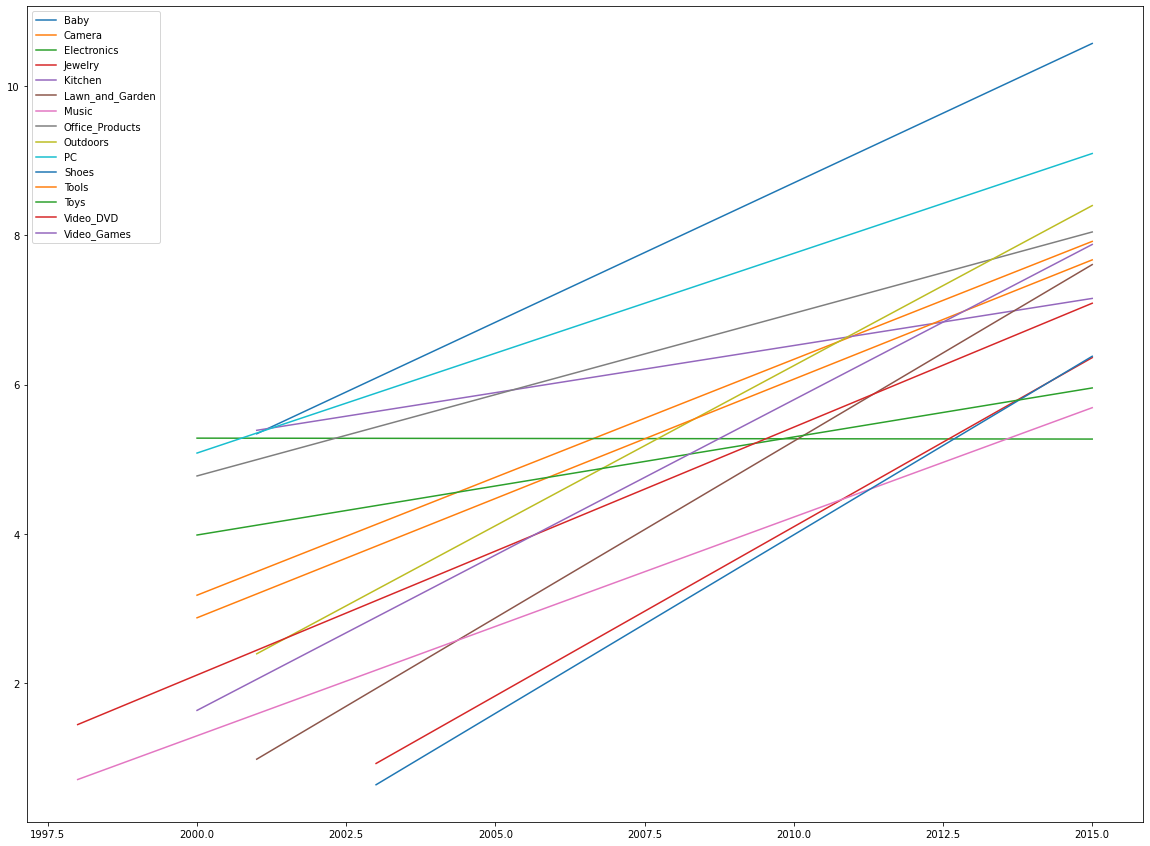

In [13]:
def plot_overlap(df):

    plt.figure(figsize=(20,15)) 

    for name, group in df.groupby('category'):
        x = group['year_from_to'].dt.year
        y = group['overlap_pct']
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        if z[0] < 0.5:
    #     plt.plot(x,y, label=name)
            plt.plot(x,p(x), label=name)

    plt.legend()
    plt.show()

plot_overlap(df_overlaps_tfidf)

**Notes**: At this point we can reflect on the results of the TF-IDF analysis to determine whether the terms which are being identified are useful, and also whether the transfer of terms across the years provides any value with respects to the overall consistency of language used within the reviews. One way of thinking about the results is that the language overlap could be considered as a metric of homogenity within the review samples. The current approach does not normalize against new products being introduced throughout the years, so it may be that this analysis is contaminated due to this factor.

### Perform Same exploration with Product Cateogry - Star Rating Analysis

In [14]:
tfidf_scores_star_rating = prepare_data_for_tfidf(df_product_category_rating)
df_overlaps_tfidf_star_rating = calc_temporal_overlap_tfidf(tfidf_scores_star_rating)
plot_overlap(df_overlaps_tfidf_star_rating)

1_stars 77649
2_stars 47438
3_stars 74790
4_stars 157552


KeyboardInterrupt: 

### Build a  multi-class classifier to determine a review category

In this method, we're going to take our learnins from the Tf-IDF experimentation, an train a simple baseline classification model to determine how well the Tf-IDF vectors represent the categories within the dataset.

The First approach will be to build the classifier with only a smaller number of categories (e.g. not segmented by year), and depending ont he results, we will start to increase the dataset labels granularity.


In [30]:
def train_bayes_classifier(df):
        
    tmp = df['review_body_processed']
    xs = []
    for entry in tmp:
        res = str(entry).strip('][').split(', ') 
        xs.append(' '.join(res))
        
    ys =  df['product_category']
    print(len(ys), len(xs))
        
    X_train, X_test, y_train, y_test = train_test_split(
        xs, ys, random_state = 0)
    print('Training Data Size: {}'.format(len(X_train)))
    count_vect = CountVectorizer(max_features=10000)
    X_train_counts = count_vect.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)    
    
    clf = LinearSVC(verbose =2)
    clf.fit(X_train_tfidf, y_train)

    return clf, count_vect, X_test, y_test
    
model, count_vect, X_test, y_test = train_bayes_classifier(sampled_data)

1437684 1437684
Training Data Size: 1078263
[LibLinear]

In [31]:
def predict(model, count_vect, X_test, y_test):
    
    X_test_counts = count_vect.transform(X_test)
    y_preds = model.predict(X_test_counts)
    print(y_preds)
    
    print(metrics.classification_report(y_test, y_preds))# target_names=df['product_category'].unique()))

    
    
predict(model, count_vect,  X_test, y_test)

['Video_DVD' 'Video_DVD' 'Music' ... 'Digital_Video_Download' 'Wireless'
 'Digital_Video_Download']
                        precision    recall  f1-score   support

               Apparel       0.55      0.69      0.61     15334
            Automotive       0.54      0.45      0.49      8824
                  Baby       0.40      0.51      0.45      4146
                Beauty       0.60      0.66      0.63     12596
                 Books       0.64      0.79      0.71     48164
                Camera       0.61      0.61      0.61      4333
Digital_Ebook_Purchase       0.69      0.57      0.62     42637
Digital_Music_Purchase       0.77      0.32      0.45      4022
Digital_Video_Download       0.59      0.40      0.47      9788
           Electronics       0.56      0.49      0.53      8007
               Grocery       0.65      0.68      0.66      5875
Health_&_Personal_Care       0.51      0.37      0.43     12910
                  Home       0.53      0.37      0.44     15425
   

**Notes**: From the results of the Tf-IFD vector implementation for modelling, the results generally look pretty accurate for both precision and recall, across all classes. It's important to remember this based on a 1% sample of the total dataset, and that we're filtering lots of the terms

The uses of this model could be to customer or operations focused,

In [39]:
sampled_data

marketplace  customer_id       review_id  product_id  product_parent  \
19015          US     33524691  R3MXPWHWGILKV3  1414339275       796015097   
19016          US     10194948  R3NJ1025B60IUA  B005B9CNMI       843768164   
19017          US     44368443  R1D3QLAO9NUWOA  093479880X       750689444   
19018          US      9925325    RIE2CLN5SXJN  B0098Y77U0       870260405   
19019          US     32418789   R38KUA0ZAZNEF  0520274822       331985887   
19020          US     35842098  R150M3AXYJMA06  B00DQZOF3Y       377453065   
19021          US     13069650  R25IPTHABBVRQ0  1607743949        12809290   
19022          US     48638849  R106MFNSN1OQKN  B009WG6JF8       185273028   
19023          US     11142482  R2K0E2DCVZJITG  1558614079       744591687   
19024          US     26667476  R3KSJVFGAX322U  B00G335A58       293177348   
19025          US      5153439  R2OE4I08OA2J0J  0716779390       360632095   
19026          US     19149799  R1AU118KLQJ7C6  B005WKIKA0       702507826   
19027          US     51497106  R1A692CR2XOEWJ  0789750716       684295605   
19028          US      3285212  R2FK4F1NFTV4QR  B00FB45SI4       687940052   
19029          US     48206779  R2TOEOAG0KOZ66  1491243821       190163110   
19030          US     30936190  R18ABAF79Y6JRV  B00C80M8V4        61877765   
19031          US     18263105  R3I6Q3TZAODMPR  1477809503       927703127   
19032          US     11282702  R3U4UOU7EL11L5  B008D1JOLE       811584944   
19033          US     49443765  R2VWPBLO996UK2  0345534492       478978331   
19034          US     45578718  R14Y2ZHSUB8EDC  B00F689T26       829869371   
19035          US     43593697  R22GPBYPNT4WKR  0698115929       673573781   
19036          US     16045228  R2WDWA0T9FNW58  B00BIFNTMC       385459547   
19037          US     51120158  R1UZ8EC5KIEF1H  0547850840       260916303   
19038          US     50389833  R2FIXBLT4AQ0LX  B009GF0KZK       782076334   
19039          US     23207650  R2L3QVRRZAOLAH  B00GG4HW0K       398564512   
19040          US     45994917  R1FY3ASI3F5K6J  B0054MS2WM       642931213   
19041          US     12095048  R37CWGVDB2IAE2  0131755536       351902688   
19042          US     19930261  R3MSCI5TSVY7LE  B00AYJFXIQ       803834671   
19043          US     44442713  R2ZGG0WV0X1N9E  1490307435       384054058   
19044          US     53025778   R67ZYND5B5FDX  B00FF8ZRPU       687822465   
...           ...          ...             ...         ...             ...   
16723          US     16371967  R10AB3VMJSKJFX  B00OMDZ8SU       928403399   
16724          US     23200030   RYQM5GICAYOD2  B00V954W6S       851440955   
16725          US      7684135  R3I3YRKNPLVY0W  B004BDP656        83882666   
16726          US     25738253  R37M9Y68R98EGJ  B008O7XX50       456196950   
16727          US       257728  R17LUQ304GJV3Q  B00NPX6MHE       350683966   
16728          US     48443154  R189297XTJTG6R  B002Y2GNVM       824624291   
16729          US     10800487   RDI41WBYG3G5Z  B004AAZQ3W       691282995   
16730          US     31427225   R6GJX36SWYOBI  B003DROHA6       120785211   
16731          US     31279491  R23L715M7YTL2U  B0110ZGNMC       656251879   
16732          US     28381214  R10AW0UMPODG6A  B00US5D784       811027049   
16733          US     10987741  R16WMKS7T389ZA  B009QPGCI4       466193707   
16734          US     43754017  R3EBH0TVCB46X8  B00YYT26YG       530928245   
16735          US     36917319   R8R872ITXIIUT  B00YNFPN82       965833951   
16736          US     51398587  R13HG1WN3AKDDZ  B00Q1UH0UG       178457212   
16737          US     13358622  R19DEZ9324OODA  B005LI5JIO       667646274   
16738          US     22517398  R1JES012D66ZKT  B00AOJOTH2       174899357   
16739          US     52525533  R21IGHIQU297PB  B00B3SM3XU       448970012   
16740          US     21919779  R3EDVOPQLI7ENT  B00CJFU2WU       873387779   
16741          US     34860150  R2MLEPIVK4PAWH  B004E2KLMC       259217343   
16742          US     160921

# YET TO BE WORKED ON

## Modelling

Here we're going to start to explore different modelling approaches to building our insights and predictive capability for this dataset.

There's a number of model's we're going to first try to develop a word embedding model which will help us develop the underlying structure of our reviews/words which can then be used as latent representations for our sentiment scores 

### Data Prep

Before we can use our data, we need to convert it from Parquet to RecordIO

In [ ]:
%%time

def read_parquet_file(filename):
    pf = ParquetFile(filename)
    return pf.to_pandas()

def convert_parquet_to_recordio(configs, manifest):
    dfs = []
     ##Create Augmented JSON Record file
    aug_train = []
    fs = s3fs.S3FileSystem()
    
    cnt = 0
    maxi = 1000000
    known_dates = {}
    tot_rows = 0
    for x in manifest:
        if cnt < maxi:
            date = x['date']
            if date not in known_dates:
                known_dates[date] = True
                absolute_path = 's3://{}/{}'.format(configs['bucket_name'], x['path_with_prefix'])
                folders = x['path_with_prefix'].split('/')
                path = ''
                for folder in folders:
                    if 'part' not in folder:
                        path = path + '/' + folder
                absolute_path = 's3://{}{}'.format(configs['bucket_name'], path)
                try:
                    dataset = pq.ParquetDataset(absolute_path,filesystem=fs)
                    table = dataset.read()
#                     df = table.to_pandas()
                    tot_rows += df.shape[0]
                    print('date {}. rows {}'.format(x['date'],df.shape[0]))
#                     dfs.append(df)
                    cnt += 1

                except:
                    print('could not load files in folder {}'.format(x['date']))
                
    print('Total Rows {}'.format(tot_rows))
    
    
#     train_file_s3 = 'train_lst/train_manifest.json'
#     s3_bucket.upload_file('./train_manifest.json', train_file_s3)

convert_parquet_to_recordio(configs, sampled_manifest)


In [ ]:
def upload_manifest(configs, manifest):
    
     ##Create Augmented JSON Record file
    aug_train = []
    
    for x in manifest:
        absolute_path = 's3://{}/{}'.format(configs['bucket_name'], x['path_with_prefix'])
        dic = {'source-ref':absolute_path}
        aug_train.append(dic)
        print(aug_train)
        break
    with open('train_manifest.json', 'w') as fout:
        for x in aug_train:
            fout.write(json.dumps(x)+'\n')
            #json.dump(aug_train, fout, indent=4)
    
        
    
#     train_file_s3 = 'train_lst/train_manifest.json'
#     s3_bucket.upload_file('./train_manifest.json', train_file_s3)

upload_manifest(configs, sampled_manifest)